In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
final_path = '../data/result/final.csv'
final = pd.read_csv(final_path)

In [3]:
final.head()

,가맹점구분번호,기준년월,가맹점 운영개월수 구간,매출금액 구간,매출건수 구간,유니크 고객 수 구간,객단가 구간,취소율 구간,배달매출금액 비율,동일 업종 매출금액 비율,...,남성 20대이하_생활인구,남성 30대_생활인구,남성 40대_생활인구,남성 50대_생활인구,남성 60대이상_생활인구,여성 20대이하_생활인구,여성 30대_생활인구,여성 40대_생활인구,여성 50대_생활인구,여성 60대이상_생활인구
0,000F03E44A,202301,5,6,5,5,4,1.0,NaN,0.5,...,963.30,2132.13,1831.82,1420.43,1492.14,1087.12,2130.12,1424.32,1298.53,1714.18
1,000F03E44A,202302,5,6,6,6,6,NaN,NaN,0.0,...,977.46,2256.90,1925.24,1487.34,1523.38,1121.90,2283.96,1511.10,1320.55,1711.70
2,000F03E44A,202303,5,6,6,6,6,NaN,NaN,0.0,...,1024.27,2222.33,1922.70,1457.60,1505.16,1090.28,2277.57,1517.81,1326.62,1712.45
3,000F03E44A,202304,5,6,5,5,3,1.0,NaN,1.3,...,1051.14,2220.44,1908.89,1443.38,1486.72,1112.18,2298.65,1515.43,1345.30,1723.41
4,000F03E44A,202305,5,6,5,5,6,1.0,NaN,0.0,...,1066.68,2163.32,1920.14,1459.71,1489.56,1113.30,2240.37,1483.60,1327.48,1694.34


In [4]:
final.columns

Index(['가맹점구분번호', '기준년월', '가맹점 운영개월수 구간', '매출금액 구간', '매출건수 구간', '유니크 고객 수 구간',
       '객단가 구간', '취소율 구간', '배달매출금액 비율', '동일 업종 매출금액 비율', '동일 업종 매출건수 비율',
       '동일 업종 내 매출 순위 비율', '동일 상권 내 매출 순위 비율', '동일 업종 내 해지 가맹점 비중',
       '동일 상권 내 해지 가맹점 비중', '남성 20대이하 고객 비중', '남성 30대 고객 비중', '남성 40대 고객 비중',
       '남성 50대 고객 비중', '남성 60대이상 고객 비중', '여성 20대이하 고객 비중', '여성 30대 고객 비중',
       '여성 40대 고객 비중', '여성 50대 고객 비중', '여성 60대이상 고객 비중', '재방문 고객 비중',
       '신규 고객 비중', '거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율', '가맹점명',
       '브랜드구분코드', '업종', '개설일', '폐업일', '행정동', '업종_대분류', '업종_중분류', 'E(기타)_이동인구',
       'H(야간거주지)_이동인구', 'W(주간거주지)_이동인구', '주말_이동인구', '평일_이동인구', '총생활인구수',
       '남성 20대이하_생활인구', '남성 30대_생활인구', '남성 40대_생활인구', '남성 50대_생활인구',
       '남성 60대이상_생활인구', '여성 20대이하_생활인구', '여성 30대_생활인구', '여성 40대_생활인구',
       '여성 50대_생활인구', '여성 60대이상_생활인구'],
      dtype='object')

In [5]:
# 폐업일이 있는 행만 필터 (빈 문자열/공백 제외)
closed = final[final['폐업일'].astype(str).str.strip().ne('') & final['폐업일'].notna()]

# 행정동별 '고유' 가맹점 수 세기
by_area = (closed
           .groupby('행정동')['가맹점구분번호']
           .nunique()                       # 가맹점 중복 제거
           .sort_values(ascending=False))

print(by_area)


행정동
사근동(행당동)            29
성수2가제1동(성수2가제3동)    26
왕십리도선동(왕십리2동)       19
성수1가제1동(성수1가제2동)    16
금호 2, 3가동           11
송정동(용답동)            10
마장동                  9
금호1가동                3
금호4가동                2
옥수동                  1
응봉동                  1
Name: 가맹점구분번호, dtype: int64


In [6]:
by_area.sum()

np.int64(127)

In [68]:
# 1) 폐업 가맹점만 추출 (공백/NaN 제외)
closed = final[final['폐업일'].astype(str).str.strip().ne('') & final['폐업일'].notna()].copy()

# 2) 행정동 × 업종_대분류별 고유 가맹점 수
dong_cat_counts = (closed
                   .groupby(['행정동', '업종_대분류'])['가맹점구분번호']
                   .nunique()
                   .reset_index(name='폐업_가맹점수')
                   .sort_values(['행정동', '폐업_가맹점수'], ascending=[True, False]))

# 이미 만든 dong_cat_counts를 전체 합산 기준 내림차순으로 정렬
ranked = (dong_cat_counts
          .sort_values(['폐업_가맹점수','행정동','업종_대분류'],
                       ascending=[False, True, True])
          .reset_index(drop=True))

ranked


,행정동,업종_대분류,폐업_가맹점수
0,성수2가제1동(성수2가제3동),한식_음식점업,9
1,사근동(행당동),한식_음식점업,8
2,왕십리도선동(왕십리2동),한식_음식점업,8
3,성수1가제1동(성수1가제2동),외국식_음식점업,7
4,마장동,음_식료품_및_담배_소매업,6
5,성수2가제1동(성수2가제3동),외국식_음식점업,6
6,"금호 2, 3가동",한식_음식점업,5
7,사근동(행당동),피자_햄버거_및_치킨_전문점,5
8,왕십리도선동(왕십리2동),피자_햄버거_및_치킨_전문점,5
9,사근동(행당동),외국식_음식점업,4


In [64]:
final['업종_대분류'].value_counts()

업종_대분류
한식_음식점업            30537
음_식료품_및_담배_소매업     13179
비알코올_음료점업          12047
외국식_음식점업           10483
주점업                 7707
피자_햄버거_및_치킨_전문점     5281
제과점업                3730
김밥_및_기타_간이_음식점업     3538
기관_구내식당업              40
Name: count, dtype: int64

---

In [18]:
df = final.copy()

In [70]:
# 필터링(공백/NaN 안전 처리)
mask = (
    df['행정동'].astype(str).str.strip().eq('성수2가제1동(성수2가제3동)') &
    df['업종_대분류'].astype(str).str.strip().eq('한식_음식점업')
)
sub = df.loc[mask].copy()

# 확인용 요약
print("행 수:", len(sub))
print("고유 가맹점 수:", sub['가맹점구분번호'].nunique())
print("폐업 가맹점 수(고유):", sub.loc[sub['폐업일'].notna(), '가맹점구분번호'].nunique())
print("기간 범위(기준년월):", sub['기준년월'].min(), "→", sub['기준년월'].max())



행 수: 7159
고유 가맹점 수: 333
폐업 가맹점 수(고유): 9
기간 범위(기준년월): 202301 → 202412


In [73]:
sub.columns

Index(['가맹점구분번호', '기준년월', '가맹점 운영개월수 구간', '매출금액 구간', '매출건수 구간', '유니크 고객 수 구간',
       '객단가 구간', '취소율 구간', '배달매출금액 비율', '동일 업종 매출금액 비율', '동일 업종 매출건수 비율',
       '동일 업종 내 매출 순위 비율', '동일 상권 내 매출 순위 비율', '동일 업종 내 해지 가맹점 비중',
       '동일 상권 내 해지 가맹점 비중', '남성 20대이하 고객 비중', '남성 30대 고객 비중', '남성 40대 고객 비중',
       '남성 50대 고객 비중', '남성 60대이상 고객 비중', '여성 20대이하 고객 비중', '여성 30대 고객 비중',
       '여성 40대 고객 비중', '여성 50대 고객 비중', '여성 60대이상 고객 비중', '재방문 고객 비중',
       '신규 고객 비중', '거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율', '가맹점명',
       '브랜드구분코드', '업종', '개설일', '폐업일', '행정동', '업종_대분류', '업종_중분류', 'E(기타)_이동인구',
       'H(야간거주지)_이동인구', 'W(주간거주지)_이동인구', '주말_이동인구', '평일_이동인구', '총생활인구수',
       '남성 20대이하_생활인구', '남성 30대_생활인구', '남성 40대_생활인구', '남성 50대_생활인구',
       '남성 60대이상_생활인구', '여성 20대이하_생활인구', '여성 30대_생활인구', '여성 40대_생활인구',
       '여성 50대_생활인구', '여성 60대이상_생활인구', '기준월', '폐업월'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
import re

# 1) 폐업 행만 필터
closed_rows = sub.loc[
    sub['폐업일'].notna() & sub['폐업일'].astype(str).str.strip().ne('')
].copy()

# 2) 가맹점별 폐업일 추출(가장 이른 값) + 보기 좋은 포맷
def pick_close_date(s):
    # 숫자만 남기고 정수로 변환
    digits = s.astype(str).str.replace(r'[^0-9]', '', regex=True)
    nums = pd.to_numeric(digits, errors='coerce').dropna().astype('Int64')
    if nums.empty:
        return pd.NA
    v = int(nums.min())              # 가장 이른 폐업일
    txt = str(v)
    if len(txt) >= 8:                # YYYYMMDD
        return f"{txt[:4]}-{txt[4:6]}-{txt[6:8]}"
    elif len(txt) >= 6:              # YYYYMM
        return f"{txt[:4]}-{txt[4:6]}"
    else:
        return txt

closed_dates = (closed_rows
    .groupby('가맹점구분번호', as_index=False)
    .agg(
        가맹점명=('가맹점명','first'),
        폐업일=('폐업일', pick_close_date),
        폐업월=('폐업월', lambda x: x.dropna().min())  # 월 단위도 함께 보고 싶을 때
    )
    .sort_values('폐업월')
    .reset_index(drop=True)
)

print("폐업 가맹점(고유) 수:", len(closed_dates))  # 기대: 9
print(closed_dates)


폐업 가맹점(고유) 수: 9
      가맹점구분번호                 가맹점명         폐업일      폐업월
0  A2C52B6B6A                 차일**  2023-08-21  2023-08
1  E476C4A851                마르***  2024-01-02  2024-01
2  A0EB1A75A7  새들*****************  2024-07-29  2024-07
3  1F369B9364              송계*****  2025-07-31  2025-07
4  202266AAE4                  쿠키*  2025-07-28  2025-07
5  C1FA7755FC       사람************  2025-07-29  2025-07
6  F7AB2719E7                  스캔*  2025-07-08  2025-07
7  81E3DAF03B              크래*****  2025-08-11  2025-08
8  69C015926E             성수******  2025-08-20  2025-08


---

폐업 가맹점(고유) 수: 9


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_7552\1485974231.py:86: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(x):


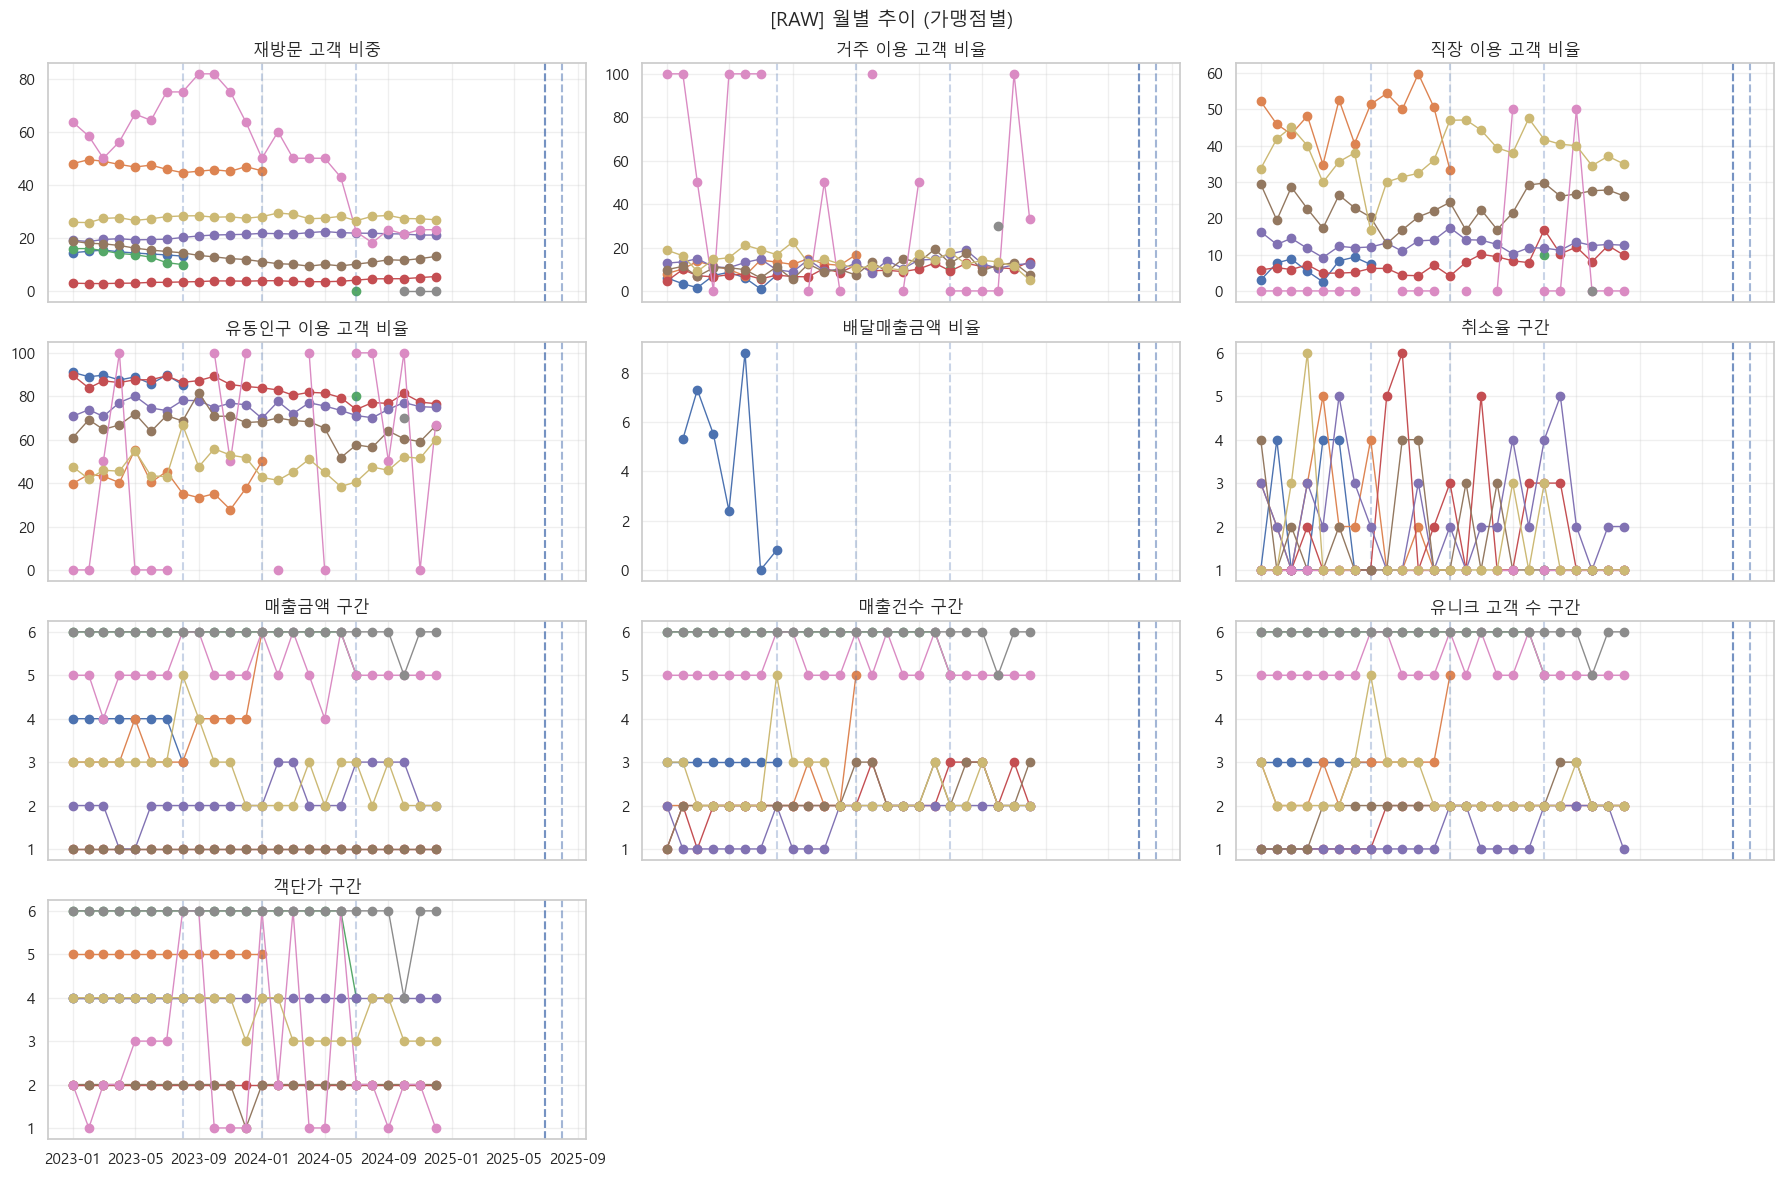

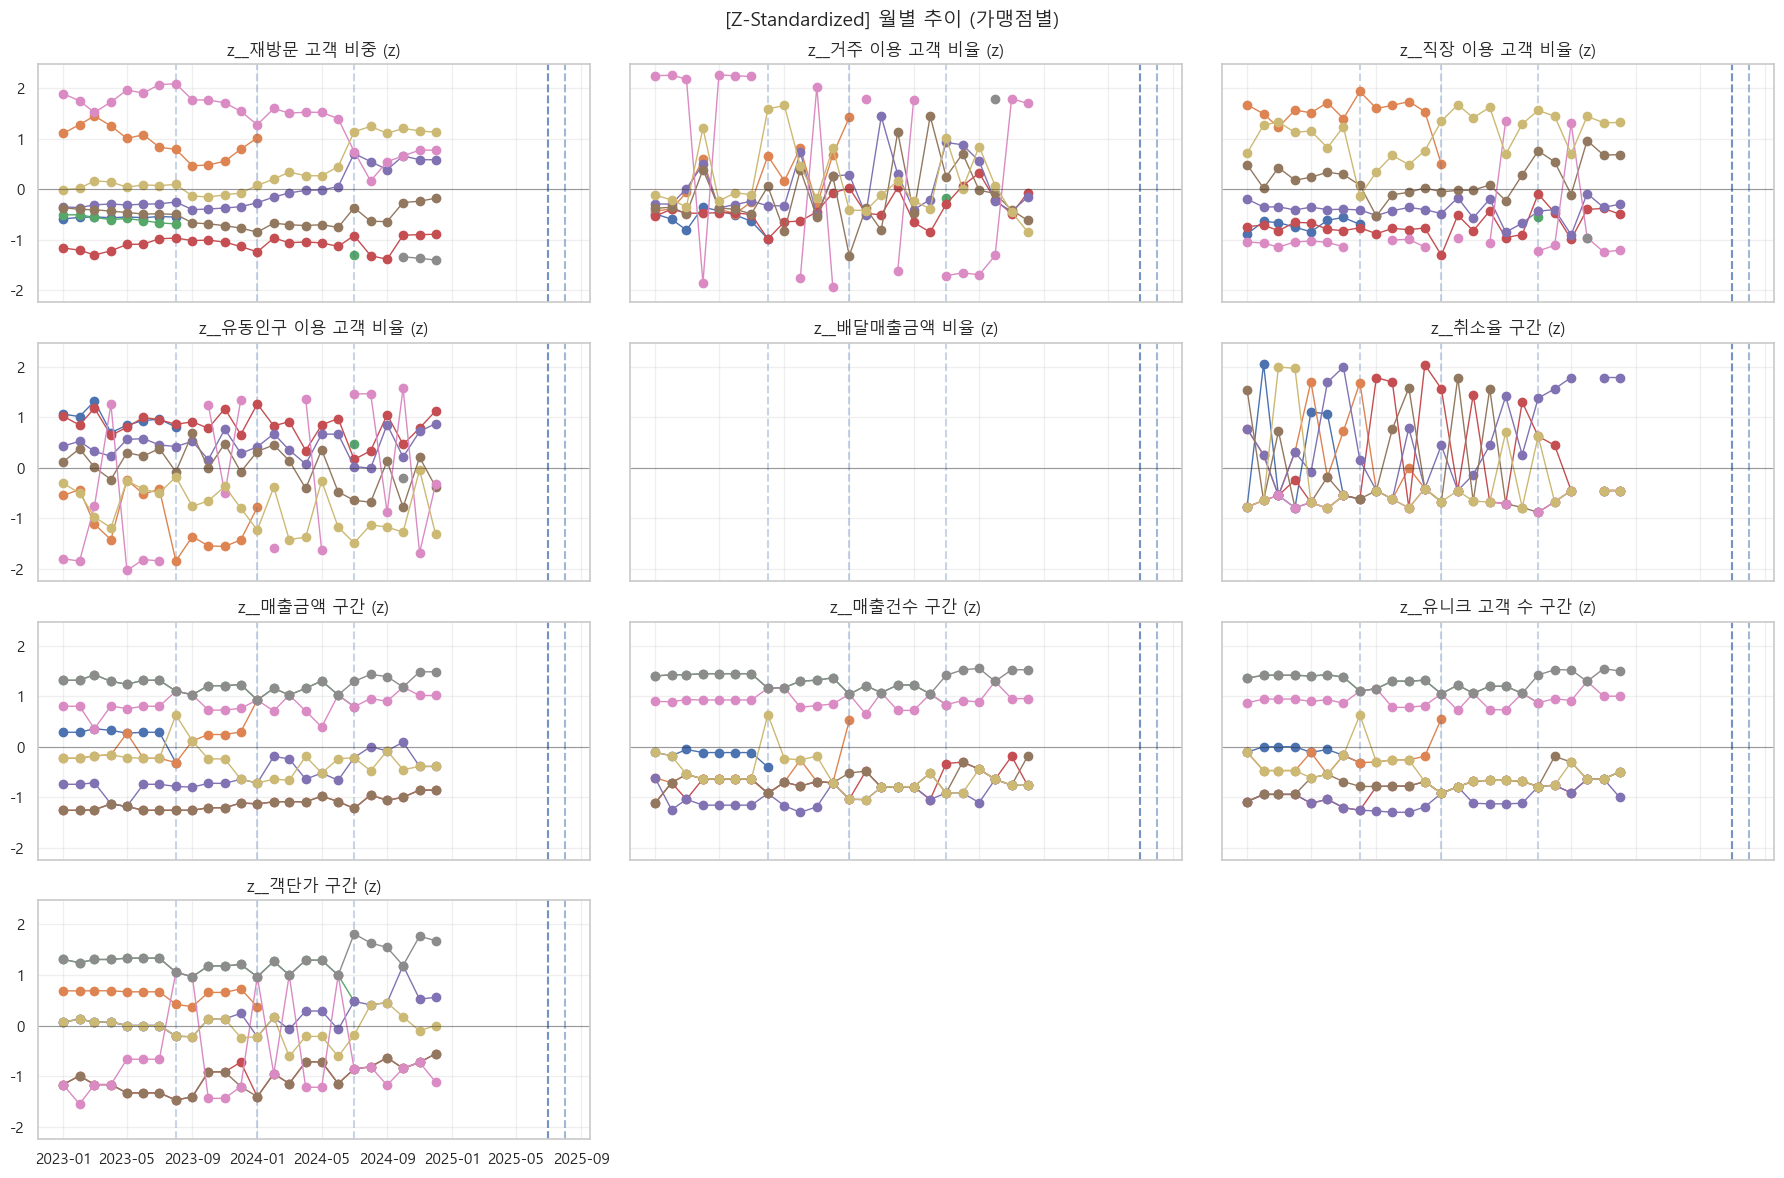

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ================================
# 0) 베이스 데이터(df0가 있으면 df0, 아니면 final)
# ================================
try:
    base_df = df0.copy()
except NameError:
    base_df = final.copy()

# 대상 세그먼트(필요 시 변경)
DONG = '성수2가제1동(성수2가제3동)'
CAT  = '한식_음식점업'

# ================================
# 1) 서브셋 + 기준월/폐업월 만들기
# ================================
sub = base_df.loc[
    base_df['행정동'].astype(str).str.strip().eq(DONG) &
    base_df['업종_대분류'].astype(str).str.strip().eq(CAT)
].copy()

# 기준월(YYYYMM → Period[M])
sub['기준월'] = pd.to_datetime(
    sub['기준년월'].astype(str), format='%Y%m', errors='coerce'
).dt.to_period('M')

# 폐업월: 폐업일에서 숫자만 추출 후 앞 6자리(YYYYMM) → Period[M]
def to_close_period(s):
    digits = s.astype(str).str.replace(r'[^0-9]', '', regex=True)
    yyyymm = digits.str[:6]
    out = pd.to_datetime(yyyymm, format='%Y%m', errors='coerce')
    return out.dt.to_period('M')

sub['폐업월'] = to_close_period(sub['폐업일'])

# ================================
# 2) 폐업 가맹점 테이블(가장 이른 폐업일/폐업월)
# ================================
def pick_close_date(s):
    digits = s.astype(str).str.replace(r'[^0-9]', '', regex=True)
    nums = pd.to_numeric(digits, errors='coerce').dropna().astype('Int64')
    if nums.empty:
        return pd.NA
    v = int(nums.min())  # 가장 이른 폐업일
    txt = str(v)
    if len(txt) >= 8:    # YYYYMMDD
        return f"{txt[:4]}-{txt[4:6]}-{txt[6:8]}"
    elif len(txt) >= 6:  # YYYYMM
        return f"{txt[:4]}-{txt[4:6]}"
    else:
        return txt

closed_rows = sub.loc[sub['폐업일'].notna() & sub['폐업일'].astype(str).str.strip().ne('')].copy()
closed_dates = (
    closed_rows.groupby('가맹점구분번호', as_index=False)
    .agg(가맹점명=('가맹점명','first'),
         폐업일=('폐업일', pick_close_date),
         폐업월=('폐업월', lambda x: x.dropna().min()))
    .sort_values('폐업월')
    .reset_index(drop=True)
)

print("폐업 가맹점(고유) 수:", len(closed_dates))
# print(closed_dates)

# ================================
# 3) 플롯용 데이터 구성 (머지/정리)
# ================================
target_shops = closed_dates['가맹점구분번호'].tolist()
plot_df = sub[sub['가맹점구분번호'].isin(target_shops)].copy()

# 기준월 datetime (x축)
plot_df['기준월_dt'] = plot_df['기준월'].dt.to_timestamp()

# 폐업월 머지(중복 컬럼 방지 및 일관 컬럼 구성)
plot_df = plot_df.merge(
    closed_dates[['가맹점구분번호', '폐업월']],
    on='가맹점구분번호', how='left', suffixes=('_sub', '_cd')
)

def to_periodM(x):
    if pd.api.types.is_period_dtype(x):
        return x
    return pd.to_datetime(x, errors='coerce').dt.to_period('M')

if '폐업월_sub' in plot_df.columns or '폐업월_cd' in plot_df.columns:
    # 두 컬럼 중 비어있지 않은 쪽 선택
    plot_df['폐업월_plot'] = plot_df[['폐업월_sub','폐업월_cd']].bfill(axis=1).iloc[:,0]
    plot_df['폐업월_plot'] = to_periodM(plot_df['폐업월_plot'])
    for c in ['폐업월_sub','폐업월_cd']:
        if c in plot_df.columns:
            plot_df.drop(columns=c, inplace=True)
elif '폐업월' in plot_df.columns:
    plot_df['폐업월_plot'] = to_periodM(plot_df['폐업월'])
else:
    plot_df['폐업월_plot'] = pd.PeriodIndex([pd.NaT]*len(plot_df), freq='M')

# ================================
# 4) (선택) 월별 z-표준화 만들기
#    - 이미 z__* 컬럼이 없으면 만들어줌(세그먼트 내 기준월별 z)
# ================================
z_prefix_exists = any(col.startswith('z__') for col in plot_df.columns)
if not z_prefix_exists:
    # 숫자 피처 후보(코드/날짜성 제외)
    num_cols = plot_df.select_dtypes(include=[np.number]).columns.tolist()
    for bad in ['기준년월','개설일','폐업일']:
        if bad in num_cols:
            num_cols.remove(bad)
    # 월별 z
    for c in num_cols:
        mu = plot_df.groupby('기준월')[c].transform('mean')
        sd = plot_df.groupby('기준월')[c].transform('std').replace(0, np.nan)
        plot_df[f'z__{c}'] = (plot_df[c] - mu) / sd

# ================================
# 5) 플롯 함수 (RAW / Z)
# ================================
def plot_metrics_raw(df, shops, metrics, ncol=3, figsize=(18, 10), sharey=False):
    nrow = int(np.ceil(len(metrics) / ncol)) if metrics else 1
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False, sharex=True, sharey=sharey)
    axes = axes.ravel()

    for i, col in enumerate(metrics):
        ax = axes[i]
        for sid in shops:
            g = df[df['가맹점구분번호'] == sid].sort_values('기준월_dt')
            if col not in g.columns:
                continue
            ax.plot(g['기준월_dt'], g[col], marker='o', linewidth=1, label=sid)

            # 폐업월 세로선
            close_p = g['폐업월_plot'].dropna().iloc[0] if g['폐업월_plot'].notna().any() else pd.NaT
            if pd.notna(close_p):
                close_dt = close_p.to_timestamp()
                ax.axvline(close_dt, linestyle='--', alpha=0.3)

        ax.set_title(col)
        ax.grid(True, alpha=0.3)

    # 남는 축 숨기기
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    fig.suptitle('[RAW] 월별 추이 (가맹점별)', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_metrics_z(df, shops, metrics, ncol=3, figsize=(18, 10), sharey=True):
    zcols = [f'z__{c}' for c in metrics if f'z__{c}' in df.columns]
    if not zcols:
        print("z 컬럼이 없습니다. (예: 'z__재방문 고객 비중') 먼저 z 표준화를 만들어 주세요.")
        return

    nrow = int(np.ceil(len(zcols) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False, sharex=True, sharey=sharey)
    axes = axes.ravel()

    for i, zc in enumerate(zcols):
        ax = axes[i]
        for sid in shops:
            g = df[df['가맹점구분번호'] == sid].sort_values('기준월_dt')
            ax.plot(g['기준월_dt'], g[zc], marker='o', linewidth=1, label=sid)

            close_p = g['폐업월_plot'].dropna().iloc[0] if g['폐업월_plot'].notna().any() else pd.NaT
            if pd.notna(close_p):
                close_dt = close_p.to_timestamp()
                ax.axvline(close_dt, linestyle='--', alpha=0.3)

        ax.set_title(f"{zc} (z)")
        ax.axhline(0.0, color='k', linewidth=0.8, alpha=0.4)  # 동월 평균선
        ax.grid(True, alpha=0.3)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    fig.suptitle('[Z-Standardized] 월별 추이 (가맹점별)', fontsize=14)
    plt.tight_layout()
    plt.show()

# ================================
# 6) 실행: 핵심 지표 세트 예시
# ================================
metrics_core = [
    '재방문 고객 비중', '거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율',
    '배달매출금액 비율', '취소율 구간',
    '매출금액 구간', '매출건수 구간', '유니크 고객 수 구간', '객단가 구간'
]

# RAW
plot_metrics_raw(plot_df, target_shops, metrics_core, ncol=3, figsize=(18, 12), sharey=False)

# Z (있으면 자동 사용)
plot_metrics_z(plot_df, target_shops, metrics_core, ncol=3, figsize=(18, 12), sharey=True)


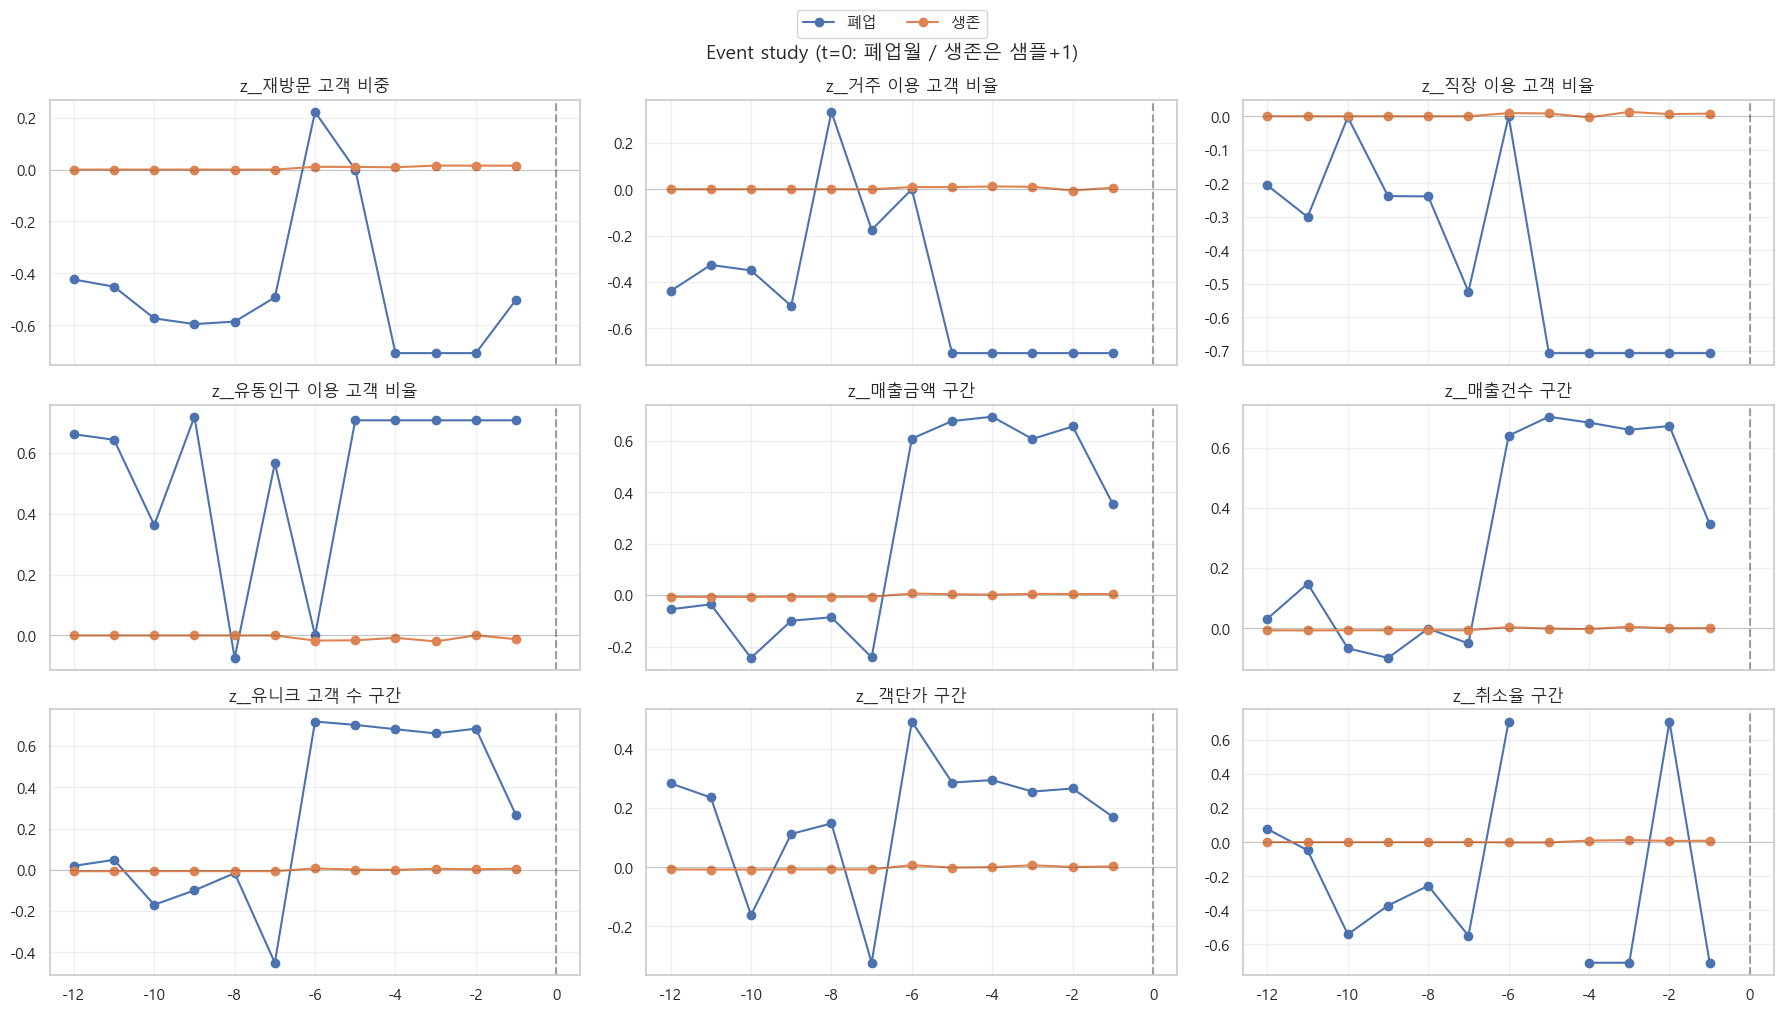

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_7552\2483595466.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_shop)
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_7552\2483595466.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_shop)
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_7552\2483595466.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is d


[직전3 − 이전3] 평균 Δ 비교 (z기준)
         feature  meanΔ_close  meanΔ_alive  diff(Δ)  n_close  n_alive
0      재방문 고객 비중        0.069        0.014    0.055        9      324
3  유동인구 이용 고객 비율        0.000       -0.020    0.020        9      324
2    직장 이용 고객 비율       -0.000        0.006   -0.006        9      324
1    거주 이용 고객 비율        0.000        0.017   -0.017        9      324
7         객단가 구간       -0.127       -0.019   -0.108        9      324
5        매출건수 구간       -0.116       -0.007   -0.110        9      324
4        매출금액 구간       -0.161       -0.014   -0.147        9      324
6    유니크 고객 수 구간       -0.231       -0.007   -0.224        9      324
8         취소율 구간       -0.236       -0.007   -0.229        9      324


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_7552\2483595466.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_shop)
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_7552\2483595466.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_shop)
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_7552\2483595466.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is d


[맨-휘트니 검정] Δ 분포 차이
       feature  meanΔ_close  meanΔ_alive  diff(Δ)  n_close  n_alive  p_value
3       객단가 구간      -0.1271      -0.0192  -0.1079        3      314   0.1075
2  유니크 고객 수 구간      -0.2308      -0.0066  -0.2242        3      314   0.2011
0      매출금액 구간      -0.1610      -0.0138  -0.1472        3      314   0.3244
1      매출건수 구간      -0.1164      -0.0069  -0.1095        3      314   0.3335


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_7552\2483595466.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_shop)


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------
# 0) 준비: 라벨/앵커(기준 0월) 만들기
#    - 폐업점 anchor = 폐업월(데이터 밖이면 그대로 0 기준만 생김)
#    - 생존점 anchor = max_month + 1개월 (표본 마지막 달이 t=-1이 되도록)
# --------------------------------
closed_set = set(closed_dates['가맹점구분번호'])
sub = sub.copy()
sub['폐업여부'] = sub['가맹점구분번호'].isin(closed_set).astype(int)

# anchor per shop
shop_anchor = {}
for sid, g in sub.groupby('가맹점구분번호'):
    if sid in closed_set:
        # 그 점포의 폐업월(가장 이른 값)
        close_m = g['폐업월'].dropna().min()
        shop_anchor[sid] = close_m  # 0월
    else:
        # 생존점은 샘플 마지막달의 다음 달을 0월로 잡아 t=-1이 마지막 관측치
        anchor = (max_month + 1)
        shop_anchor[sid] = anchor

sub['anchor_month'] = sub['가맹점구분번호'].map(shop_anchor)

# 상대월 계산: t = 기준월 - anchor (개월 단위)
def month_index(p):
    return p.dt.year * 12 + p.dt.month

t_idx  = month_index(sub['기준월'])
a_idx  = month_index(sub['anchor_month'])
sub['t_to_close'] = t_idx - a_idx    # 폐업 전은 음수, 폐업월이 0

# 분석 윈도우(폐업 직전 12개월~직전 1개월)
win_lo, win_hi = -12, -1
mask_win = (sub['t_to_close'] >= win_lo) & (sub['t_to_close'] <= win_hi)
sub_win = sub.loc[mask_win].copy()

# --------------------------------
# 1) z 표준화가 없으면 생성(동월 기준)
# --------------------------------
z_prefix_exists = any(c.startswith('z__') for c in sub_win.columns)
if not z_prefix_exists:
    num_cols = sub_win.select_dtypes(include=[np.number]).columns.tolist()
    for bad in ['기준년월','개설일','폐업일','폐업여부','t_to_close']:
        if bad in num_cols:
            num_cols.remove(bad)
    for c in num_cols:
        mu = sub_win.groupby('기준월')[c].transform('mean')
        sd = sub_win.groupby('기준월')[c].transform('std').replace(0, np.nan)
        sub_win[f'z__{c}'] = (sub_win[c] - mu) / sd

# --------------------------------
# 2) 상대월 평균(폐업군/생존군) 곡선 그리기
# --------------------------------
def plot_event_study(df, cols, title='Event study (t=0: 폐업월 / 생존은 샘플+1)'):
    n = len(cols)
    ncol = 3
    nrow = int(np.ceil(n/ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=(18, 10), sharex=True, squeeze=False)
    axes = axes.ravel()
    for i, col in enumerate(cols):
        ax = axes[i]
        zc = f'z__{col}'
        if zc not in df.columns:
            ax.set_visible(False); continue
        g = (df.groupby(['폐업여부','t_to_close'])[zc]
               .mean()
               .unstack(0)  # col 0: 생존, 1: 폐업
               .reindex(range(win_lo, win_hi+1)))
        ax.plot(g.index, g.get(1), marker='o', label='폐업', linewidth=1.5)
        ax.plot(g.index, g.get(0), marker='o', label='생존', linewidth=1.5)
        ax.axvline(0, color='k', linestyle='--', alpha=0.4)
        ax.axhline(0, color='k', linewidth=0.8, alpha=0.2)
        ax.set_title(f'z__{col}')
        ax.grid(alpha=0.3)
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    fig.suptitle(title, fontsize=14)
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02))
    plt.tight_layout()
    plt.show()

metrics_es = [
    '재방문 고객 비중', '거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율',
    '매출금액 구간', '매출건수 구간', '유니크 고객 수 구간', '객단가 구간', '취소율 구간'
]
plot_event_study(sub_win, metrics_es)

# --------------------------------
# 3) “직전3 − 이전3” 변화량(Δ)로 비교 (점포 단위)
#    t∈[-3,-1] 평균 − t∈[-6,-4] 평균
# --------------------------------
def last3_prev3_delta(df, col):
    zc = f'z__{col}'
    if zc not in df.columns: 
        return pd.Series(dtype='float64')
    def agg_shop(g):
        g = g.dropna(subset=['t_to_close'])
        v = g.set_index('t_to_close')[zc]
        last3 = v.reindex([-3,-2,-1]).mean()   # 직전 3개월
        prev3 = v.reindex([-6,-5,-4]).mean()   # 그 이전 3개월
        return pd.Series({'delta': last3 - prev3})
    out = (df.groupby(['가맹점구분번호','폐업여부'])
             .apply(agg_shop)
             .reset_index())
    return out

rows = []
for c in metrics_es:
    d = last3_prev3_delta(sub_win, c)
    if d.empty: 
        continue
    m1 = d.loc[d['폐업여부']==1, 'delta'].mean()
    m0 = d.loc[d['폐업여부']==0, 'delta'].mean()
    n1 = d.loc[d['폐업여부']==1].shape[0]
    n0 = d.loc[d['폐업여부']==0].shape[0]
    rows.append([c, m1, m0, m1-m0, n1, n0])
delta_tbl = pd.DataFrame(rows, columns=['feature','meanΔ_close','meanΔ_alive','diff(Δ)','n_close','n_alive'])
print("\n[직전3 − 이전3] 평균 Δ 비교 (z기준)")
print(delta_tbl.sort_values('diff(Δ)', ascending=False).round(3))

# --------------------------------
# 4) 간단 유의성 체크(맨-휘트니, 비모수) — 선택
# --------------------------------
try:
    from scipy.stats import mannwhitneyu
    tests = []
    for c in metrics_es:
        d = last3_prev3_delta(sub_win, c)
        if d.empty: 
            continue
        a = d.loc[d['폐업여부']==1, 'delta'].dropna()
        b = d.loc[d['폐업여부']==0, 'delta'].dropna()
        if len(a) >= 3 and len(b) >= 10:
            u, p = mannwhitneyu(a, b, alternative='two-sided')
            tests.append([c, float(a.mean()), float(b.mean()), float(a.mean()-b.mean()), len(a), len(b), float(p)])
    if tests:
        test_tbl = pd.DataFrame(tests, columns=['feature','meanΔ_close','meanΔ_alive','diff(Δ)','n_close','n_alive','p_value'])
        print("\n[맨-휘트니 검정] Δ 분포 차이")
        print(test_tbl.sort_values('p_value').round(4))
except Exception as e:
    print("\n(scipy가 없으면 이 블록은 건너뜀)", e)


---

In [79]:
import pandas as pd
import numpy as np
import re

# ================================
# 0) 베이스 데이터 선택(df0가 있으면 df0, 아니면 final)
# ================================
try:
    base_df = df0.copy()
except NameError:
    base_df = final.copy()

# 대상 세그먼트
DONG = '성수2가제1동(성수2가제3동)'
CAT  = '한식_음식점업'

# ================================
# 1) 서브셋 + 기준월/폐업월 만들기 (월 Period)
# ================================
sub = base_df.loc[
    base_df['행정동'].astype(str).str.strip().eq(DONG) &
    base_df['업종_대분류'].astype(str).str.strip().eq(CAT)
].copy()

# 기준월
sub['기준월'] = pd.to_datetime(sub['기준년월'].astype(str), format='%Y%m', errors='coerce').dt.to_period('M')

# 폐업월: 폐업일(YYYYMMDD/YYYMM 혼재 → 숫자만 추출해 앞6자리 사용)
def to_close_period(s):
    digits = s.astype(str).str.replace(r'[^0-9]', '', regex=True)
    yyyymm = digits.str[:6]
    out = pd.to_datetime(yyyymm, format='%Y%m', errors='coerce')
    return out.dt.to_period('M')

sub['폐업월'] = to_close_period(sub['폐업일'])

# 생존/폐업 점포 개수 확인(가맹점 단위)
closed_shops = sub.loc[sub['폐업월'].notna(), '가맹점구분번호'].drop_duplicates()
alive_shops  = sub.loc[~sub['가맹점구분번호'].isin(closed_shops), '가맹점구분번호'].drop_duplicates()
print("고유 가맹점 수:", sub['가맹점구분번호'].nunique())
print("폐업 가맹점 수:", closed_shops.nunique())
print("생존 가맹점 수:", alive_shops.nunique())

# ================================
# 2) 스냅샷 기준월 t_i 설정 (누수 방지)  <<<< 수정 핵심
#    - 폐업점: min(폐업월-1, 데이터의 최대 기준월)
#    - 생존점: 데이터의 최대 기준월
#    ※ 네 데이터는 2023-01~2024-12라 가정 → max_month=2024-12
# ================================
max_month = sub['기준월'].max()   # 보통 2024-12 (Period[M])

sub['폐업직전월'] = sub['폐업월'] - 1   # Period 연산 → NaT는 그대로 남음

# np.where 대신, Period dtype 유지되는 판다스 방식으로 처리
# 1) 폐업점 후보: min(폐업직전월, max_month)
candidate = sub['폐업직전월']
candidate = candidate.where(candidate <= max_month, max_month)  # 더 이른 값(=min)

# 2) 생존점은 max_month
sub['last_obs_month'] = candidate.where(sub['폐업월'].notna(), max_month)

# 확인
# print(sub[['기준월','폐업월','폐업직전월','last_obs_month']].head())
# print("last_obs_month dtype:", sub['last_obs_month'].dtype)  # period[M]이어야 정상

# ================================
# 3) 월별 표준화(z) (시점 차이 보정)
#    - 같은 세그먼트(성수2×한식) 내에서 기준월별 평균/표준편차로 z-transform
# ================================
# 숫자 피처 후보(라벨/키/날짜성 컬럼 제외)
num_cols = sub.select_dtypes(include=[np.number]).columns.tolist()
for bad in ['기준년월','개설일','폐업일']:  # 원시 날짜/코드성 숫자는 제외
    if bad in num_cols:
        num_cols.remove(bad)

# 월별 z값 생성
z_cols = []
for c in num_cols:
    mu = sub.groupby('기준월')[c].transform('mean')
    sd = sub.groupby('기준월')[c].transform('std').replace(0, np.nan)
    zname = f"z__{c}"
    sub[zname] = (sub[c] - mu) / sd
    z_cols.append(zname)

# ================================
# 4) 최근 3개월 창(t_i, t_i-1, t_i-2)의 z-평균 → 가맹점당 1행 스냅샷
# ================================
def last3_zmean(g):
    t = g['last_obs_month'].iloc[0]
    if pd.isna(t):
        return pd.Series(index=z_cols, dtype='float64')
    win = g[(g['기준월'] <= t) & (g['기준월'] >= (t - 2))]  # t, t-1, t-2
    return win[z_cols].mean(numeric_only=True)               # 있는 값만 평균

snap = (sub.groupby('가맹점구분번호', group_keys=False)
          .apply(last3_zmean))

# 라벨(ever-폐업: 이 세그먼트 내 폐업월 유무)
shop_label = (sub.groupby('가맹점구분번호')['폐업월']
                .first().notna().astype(int).rename('폐업여부'))

snap_tbl = snap.join(shop_label, how='left')
print("스냅샷 표 크기:", snap_tbl.shape)
print("스냅샷 라벨 분포:\n", snap_tbl['폐업여부'].value_counts().sort_index())

# ================================
# 5) 폐업 vs 생존: 특징 비교
#    - 표준화 차이: (폐업평균 - 생존평균) / (전체표준편차)
#    - 방향 해석: +면 폐업점이 상대적으로 높음, -면 생존이 높음(보호 신호)
# ================================
features = z_cols  # z-피처들
Y = snap_tbl['폐업여부'].astype(int)

rows = []
for zc in features:
    x = pd.to_numeric(snap_tbl[zc], errors='coerce')
    if x.notna().sum() < 20:  # 결측 많으면 스킵(표본 확보 임계)
        continue
    s = x.std(ddof=0)
    if not np.isfinite(s) or s == 0:
        continue
    m1 = x[Y==1].mean()
    m0 = x[Y==0].mean()
    std_diff = (m1 - m0) / s
    rows.append((zc.replace('z__',''), m1, m0, std_diff))

feat_cmp = (pd.DataFrame(rows, columns=['feature','mean_close_z','mean_alive_z','std_diff'])
              .assign(abs_std=lambda d: d['std_diff'].abs())
              .sort_values('abs_std', ascending=False))

print("\n[폐업 vs 생존: z-표준화 차이 Top 20]")
print(feat_cmp.head(20).round(3))

# ================================
# 6) 리프트 예시(권장): 배달 z 상위25% vs 하위25%, 재방문 z 하위25% 등
# ================================
def lift_report(col_z, upper=0.75, lower=0.25):
    q_hi = snap_tbl[col_z].quantile(upper)
    q_lo = snap_tbl[col_z].quantile(lower)
    m_hi = snap_tbl[col_z] >= q_hi
    m_lo = snap_tbl[col_z] <= q_lo
    return {
        'col': col_z.replace('z__',''),
        'hi_rate': float(Y[m_hi].mean()),
        'lo_rate': float(Y[m_lo].mean()),
        'hi_n': int(m_hi.sum()),
        'lo_n': int(m_lo.sum()),
    }

cols_for_lift = []
for name in ['배달매출금액 비율','재방문 고객 비중','거주 이용 고객 비율','유동인구 이용 고객 비율',
             '매출금액 구간','매출건수 구간','유니크 고객 수 구간','객단가 구간','취소율 구간']:
    zname = f"z__{name}"
    if zname in snap_tbl.columns:
        cols_for_lift.append(zname)

lift_rows = [lift_report(c) for c in cols_for_lift]
lift_df = pd.DataFrame(lift_rows)
if not lift_df.empty:
    print("\n[분위수 리프트(상위25% vs 하위25%)]")
    print(lift_df.sort_values('hi_rate', ascending=False).round(4))

# ================================
# 7) 교차조건 리프트(예: 배달 z 상위25% ∧ 재방문 z 하위25%)
# ================================
if {'z__배달매출금액 비율','z__재방문 고객 비중'}.issubset(snap_tbl.columns):
    q75_deliv = snap_tbl['z__배달매출금액 비율'].quantile(0.75)
    q25_repeat = snap_tbl['z__재방문 고객 비중'].quantile(0.25)

    m_cross = (snap_tbl['z__배달매출금액 비율'] >= q75_deliv) & \
              (snap_tbl['z__재방문 고객 비중'] <= q25_repeat)
    rate_in  = Y[m_cross].mean()
    rate_out = Y[~m_cross].mean()

    print("\n[교차조건 리프트] 배달 z 상위25% ∧ 재방문 z 하위25%")
    print(f"조건집단 폐업률: {rate_in:.4f}  표본수: {int(m_cross.sum())}")
    print(f"나머지   폐업률: {rate_out:.4f}  표본수: {int((~m_cross).sum())}")

# ================================
# 8) 해석 가이드(요약)
# - std_diff > 0: 폐업점이 상대적으로 높은(나쁜) z 수준
# - std_diff < 0: 생존점이 더 높은(보호) z 수준
# - '구간'(값 클수록 나쁨) 지표는 +면 취약 신호, '재방문/거주'는 -면 보호 신호
# ================================


고유 가맹점 수: 333
폐업 가맹점 수: 9
생존 가맹점 수: 324
스냅샷 표 크기: (333, 45)
스냅샷 라벨 분포:
 폐업여부
0    324
1      9
Name: count, dtype: int64

[폐업 vs 생존: z-표준화 차이 Top 20]
              feature  mean_close_z  mean_alive_z  std_diff  abs_std
18     여성 20대이하 고객 비중         1.390        -0.021     1.398    1.398
19       여성 30대 고객 비중         0.945        -0.016     0.960    0.960
22     여성 60대이상 고객 비중        -0.661         0.008    -0.708    0.708
27      유동인구 이용 고객 비율         0.543         0.010     0.594    0.594
6           배달매출금액 비율        -0.562        -0.003    -0.577    0.577
5              취소율 구간        -0.359         0.011    -0.561    0.561
11  동일 업종 내 해지 가맹점 비중        -0.426         0.006    -0.557    0.557
23          재방문 고객 비중        -0.540         0.002    -0.548    0.548
14       남성 30대 고객 비중        -0.540        -0.000    -0.540    0.540
15       남성 40대 고객 비중        -0.522         0.015    -0.536    0.536
17     남성 60대이상 고객 비중        -0.493         0.006    -0.508    0.508
21       여성 50대 고객 비중 

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_7552\2551190940.py:96: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(last3_zmean))


In [80]:
rules = {
    "배달 하위25% ∧ 재방문 하위25%": {
        "deliv": ("low", 0.25),
        "repeat": ("low", 0.25),
    },
    "배달 하위33% ∧ 재방문 하위33%": {
        "deliv": ("low", 1/3),
        "repeat": ("low", 1/3),
    },
    "배달 하위40% ∧ 재방문 하위40%": {
        "deliv": ("low", 0.40),
        "repeat": ("low", 0.40),
    },
}

def mask_quantile(s, mode, q):
    thr = s.quantile(q)
    return (s <= thr) if mode == "low" else (s >= thr)

def check_rule(deliv_col='z__배달매출금액 비율', repeat_col='z__재방문 고객 비중'):
    out = []
    for name, spec in rules.items():
        m1 = mask_quantile(snap_tbl[deliv_col], *spec["deliv"])
        m2 = mask_quantile(snap_tbl[repeat_col], *spec["repeat"])
        m = m1 & m2
        n_in  = int(m.sum())
        n_out = int((~m).sum())
        r_in  = float(Y[m].mean()) if n_in>0 else 0.0
        r_out = float(Y[~m].mean()) if n_out>0 else 0.0
        out.append([name, r_in, n_in, r_out, n_out, (r_in - r_out)])
    return pd.DataFrame(out, columns=["rule","rate_in","n_in","rate_out","n_out","lift"]).sort_values("lift", ascending=False)

print(check_rule())


                   rule  rate_in  n_in  rate_out  n_out      lift
0  배달 하위25% ∧ 재방문 하위25%      0.0     5  0.027439    328 -0.027439
1  배달 하위33% ∧ 재방문 하위33%      0.0     9  0.027778    324 -0.027778
2  배달 하위40% ∧ 재방문 하위40%      0.0    17  0.028481    316 -0.028481


---

In [8]:
import pandas as pd
import numpy as np

df0 = final.copy()  # 원본 보존

In [9]:
print("행/열 크기:", df0.shape)
print("\n컬럼 타입 요약:")
print(df0.dtypes)

print("\n숫자형 기본 통계(앞부분):")
print(df0.select_dtypes(include=[np.number]).describe().T.head(15))

print("\n문자형 카테고리 후보(레벨 수):")
cat_cols = ['행정동','업종','브랜드구분코드','업종_대분류','업종_중분류']
for c in cat_cols:
    if c in df0.columns:
        print(c, df0[c].nunique())

행/열 크기: (86542, 54)

컬럼 타입 요약:
가맹점구분번호               object
기준년월                   int64
가맹점 운영개월수 구간           int64
매출금액 구간                int64
매출건수 구간                int64
유니크 고객 수 구간            int64
객단가 구간                 int64
취소율 구간               float64
배달매출금액 비율            float64
동일 업종 매출금액 비율        float64
동일 업종 매출건수 비율        float64
동일 업종 내 매출 순위 비율     float64
동일 상권 내 매출 순위 비율     float64
동일 업종 내 해지 가맹점 비중    float64
동일 상권 내 해지 가맹점 비중    float64
남성 20대이하 고객 비중       float64
남성 30대 고객 비중         float64
남성 40대 고객 비중         float64
남성 50대 고객 비중         float64
남성 60대이상 고객 비중       float64
여성 20대이하 고객 비중       float64
여성 30대 고객 비중         float64
여성 40대 고객 비중         float64
여성 50대 고객 비중         float64
여성 60대이상 고객 비중       float64
재방문 고객 비중            float64
신규 고객 비중             float64
거주 이용 고객 비율          float64
직장 이용 고객 비율          float64
유동인구 이용 고객 비율        float64
가맹점명                  object
브랜드구분코드               object
업종                    object
개설일         

#### '배달매출금액 비율'이 100%를 넘는 경우

In [10]:
import numpy as np

col = '배달매출금액 비율'

# 1) 100 초과 여부 마스크
mask = df0[col].notna() & (df0[col] > 100)

# 2) 몇 개인지
count_over = mask.sum()
print("100 초과 건수:", int(count_over))

# 3) 그 값들(전체 목록)
vals = df0.loc[mask, col].sort_values()
print(vals)

100 초과 건수: 1
27968    111.2
Name: 배달매출금액 비율, dtype: float64


- 111.2 하나 있음 -> 100으로 대체

In [11]:
df0['배달매출금액 비율'] = df0['배달매출금액 비율'].clip(upper=100)

#### 비율 스케일(0~1을 0~100으로 통일)/이상치 플래그 정돈

In [12]:
import numpy as np
import pandas as pd

# 1-1. 퍼센트(0~100)로 다루는 후보들
pct_cols = [
 '배달매출금액 비율','동일 업종 내 매출 순위 비율','동일 상권 내 매출 순위 비율',
 '동일 업종 내 해지 가맹점 비중','동일 상권 내 해지 가맹점 비중',
 '재방문 고객 비중','신규 고객 비중','거주 이용 고객 비율','직장 이용 고객 비율','유동인구 이용 고객 비율'
] + [c for c in df0.columns if '고객 비중' in c and ('남성' in c or '여성' in c)]

# 1-2. 0~1 스케일이 섞였으면 100배 (자동 판정)
for c in pct_cols:
    if c in df0.columns and df0[c].dropna().max() <= 1.5:
        df0[c] = df0[c] * 100.0

# 1-3. 명백한 범위 밖 값 플래그(음수/120% 초과) 기록만, 값은 그대로 두기
for c in pct_cols:
    if c in df0.columns:
        df0[f'{c}_flag_out'] = df0[c].notna() & ~df0[c].between(0, 120)


In [13]:
# 1) flag_out 컬럼들 찾기
flag_cols = [c for c in df0.columns if c.endswith('_flag_out')]

# 2) True가 한 번도 없었던(flag가 전혀 안 켜진) 컬럼 식별
drop_flags = []
for c in flag_cols:
    # NaN은 False로 간주하고, bool로 변환해 any() 체크
    has_true = df0[c].fillna(False).astype(bool).any()
    if not has_true:
        drop_flags.append(c)

# 3) 제거
df0.drop(columns=drop_flags, inplace=True)

# 4) 로그(선택)
print("제거한 flag_out 컬럼:", drop_flags if drop_flags else "없음")


제거한 flag_out 컬럼: ['배달매출금액 비율_flag_out', '동일 업종 내 매출 순위 비율_flag_out', '동일 상권 내 매출 순위 비율_flag_out', '동일 업종 내 해지 가맹점 비중_flag_out', '동일 상권 내 해지 가맹점 비중_flag_out', '재방문 고객 비중_flag_out', '신규 고객 비중_flag_out', '거주 이용 고객 비율_flag_out', '직장 이용 고객 비율_flag_out', '유동인구 이용 고객 비율_flag_out', '남성 20대이하 고객 비중_flag_out', '남성 30대 고객 비중_flag_out', '남성 40대 고객 비중_flag_out', '남성 50대 고객 비중_flag_out', '남성 60대이상 고객 비중_flag_out', '여성 20대이하 고객 비중_flag_out', '여성 30대 고객 비중_flag_out', '여성 40대 고객 비중_flag_out', '여성 50대 고객 비중_flag_out', '여성 60대이상 고객 비중_flag_out']


#### 기준년월 -> 기준월 컬럼 추가

In [14]:
if '기준년월' in df0.columns:
    df0['기준월'] = pd.to_datetime(df0['기준년월'].astype(str), format='%Y%m', errors='coerce').dt.to_period('M')
else:
    df0['기준월'] = pd.NaT

#### 핵심 상관(스피어만)

In [15]:
core = [
 '취소율 구간','매출금액 구간','매출건수 구간','유니크 고객 수 구간','객단가 구간',
 '재방문 고객 비중','신규 고객 비중','배달매출금액 비율',
 '동일 업종 내 매출 순위 비율','동일 상권 내 매출 순위 비율',
 '동일 업종 내 해지 가맹점 비중','동일 상권 내 해지 가맹점 비중'
]
use = [c for c in core if c in df0.columns]
corr = df0[use].corr(method='spearman').round(2)
print(corr)


                   취소율 구간  매출금액 구간  매출건수 구간  유니크 고객 수 구간  객단가 구간  재방문 고객 비중  \
취소율 구간               1.00    -0.31    -0.39        -0.39    0.16       0.06   
매출금액 구간             -0.31     1.00     0.74         0.77    0.38       0.04   
매출건수 구간             -0.39     0.74     1.00         0.96   -0.14      -0.25   
유니크 고객 수 구간         -0.39     0.77     0.96         1.00   -0.10      -0.17   
객단가 구간               0.16     0.38    -0.14        -0.10    1.00       0.33   
재방문 고객 비중            0.06     0.04    -0.25        -0.17    0.33       1.00   
신규 고객 비중             0.07    -0.29    -0.25        -0.27   -0.20      -0.22   
배달매출금액 비율           -0.13     0.39     0.36         0.35    0.02      -0.05   
동일 업종 내 매출 순위 비율    -0.27     0.83     0.66         0.69    0.28      -0.04   
동일 상권 내 매출 순위 비율    -0.13     0.39     0.31         0.32    0.12      -0.13   
동일 업종 내 해지 가맹점 비중   -0.03    -0.17    -0.03        -0.05   -0.25      -0.16   
동일 상권 내 해지 가맹점 비중    0.02    -0.08    -0.14        -

In [16]:
# --- 1. Seaborn 스타일을 가장 먼저 설정합니다 ---
# 이 코드가 실행되면서 한글 폰트 설정이 초기화됩니다.
sns.set(style='whitegrid')

# --- 2. 초기화된 폰트 설정을 다시 한글로 지정합니다 ---
# (이전에 사용했던 한글 폰트 설정 코드를 그대로 다시 실행)
import platform
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')
else: # Linux
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

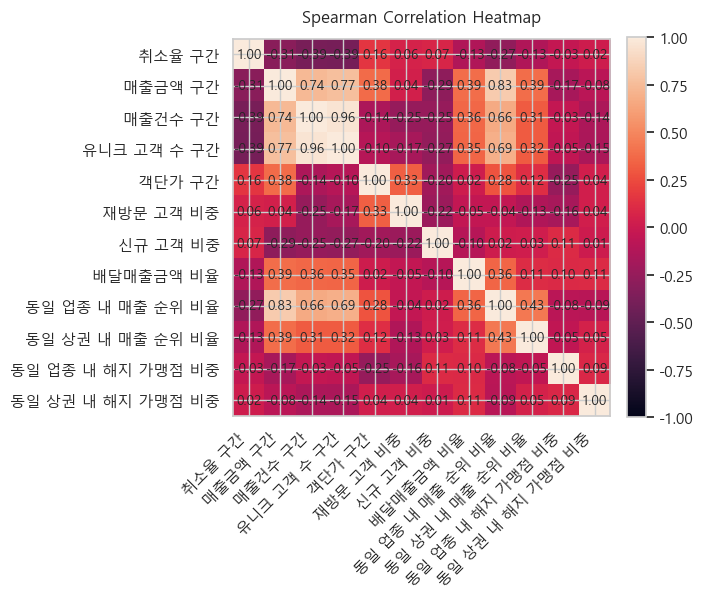

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) 사용할 컬럼 목록(있는 것만 사용)
core = [
    '취소율 구간','매출금액 구간','매출건수 구간','유니크 고객 수 구간','객단가 구간',
    '재방문 고객 비중','신규 고객 비중','배달매출금액 비율',
    '동일 업종 내 매출 순위 비율','동일 상권 내 매출 순위 비율',
    '동일 업종 내 해지 가맹점 비중','동일 상권 내 해지 가맹점 비중'
]
use_cols = [c for c in core if c in df0.columns]

# 2) 스피어만 상관계수
corr = df0[use_cols].corr(method='spearman')

# 3) 그림 크기(변수 개수에 따라 자동 조절) + 히트맵
n = len(use_cols)
fig_w = max(6, n * 0.6)
fig_h = max(6, n * 0.6)
plt.figure(figsize=(fig_w, fig_h))

im = plt.imshow(corr.values, vmin=-1, vmax=1)  # 색상은 기본값 사용
plt.colorbar(im, fraction=0.046, pad=0.04)

# 4) 축 라벨
plt.xticks(ticks=np.arange(n), labels=use_cols, rotation=45, ha='right')
plt.yticks(ticks=np.arange(n), labels=use_cols)

plt.title('Spearman Correlation Heatmap', pad=12)

# 5) 셀 안에 값(소수 둘째자리) 표시
# 글자 크기는 변수 개수에 따라 자동 조절
fs = max(6, 12 - 0.2 * n)
for i in range(n):
    for j in range(n):
        val = corr.iloc[i, j]
        plt.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=fs)

plt.tight_layout()
plt.show()


#### 

In [84]:
metrics = ['취소율 구간','재방문 고객 비중','동일 업종 내 매출 순위 비율']
use_cols = [m for m in metrics if m in df1.columns]

pivots = {}
for m in use_cols:
    piv = df1.pivot_table(index='행정동', columns='업종_대분류', values=m, aggfunc='mean')
    pivots[m] = piv
    print(f"\n[{m}] 피벗 (상위 5행):\n", piv.head().round(2))



[취소율 구간] 피벗 (상위 5행):
 업종_대분류     기관_구내식당업  김밥_및_기타_간이_음식점업  비알코올_음료점업  외국식_음식점업  음_식료품_및_담배_소매업  \
행정동                                                                         
금호 2, 3가동       NaN             2.19       2.45      1.77            1.78   
금호1가동           NaN             1.39       2.32      2.02            1.72   
금호4가동           NaN             2.21       2.38      2.18            1.60   
마장동             NaN             1.70       2.22      2.32            1.84   
사근동(행당동)       1.22             2.06       2.60      2.05            1.70   

업종_대분류     제과점업   주점업  피자_햄버거_및_치킨_전문점  한식_음식점업  
행정동                                              
금호 2, 3가동  2.15  1.33             2.06     1.82  
금호1가동      1.88  1.49             1.88     1.93  
금호4가동      2.82  1.56             1.78     1.71  
마장동        2.97  1.66             2.10     2.12  
사근동(행당동)   2.31  1.95             2.34     2.11  

[재방문 고객 비중] 피벗 (상위 5행):
 업종_대분류     기관_구내식당업  김밥_및_기타_간이_음식점업  비알코올_음료점업  외국식_음식점업  음_

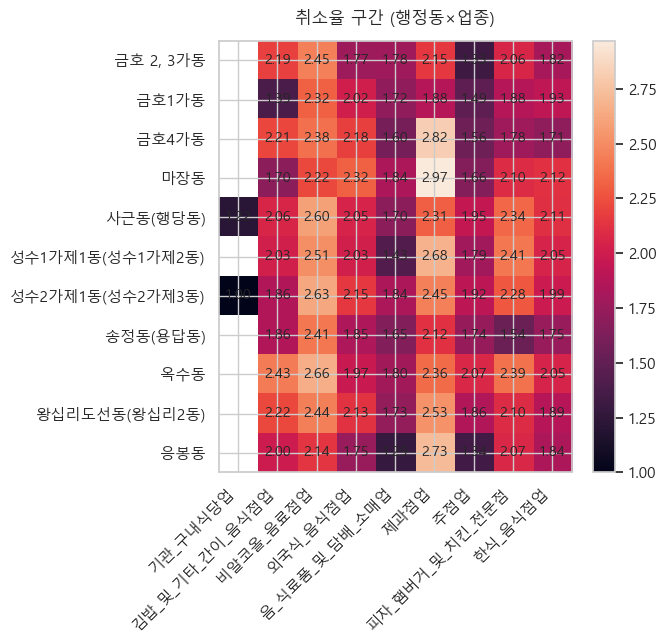

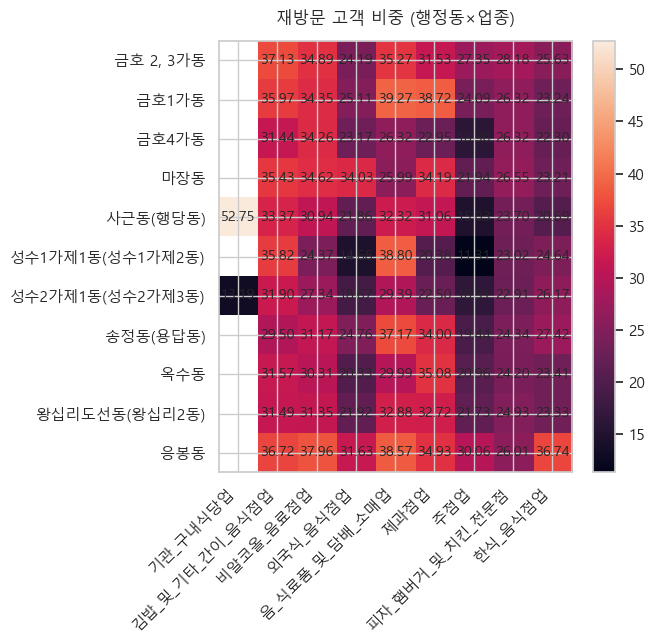

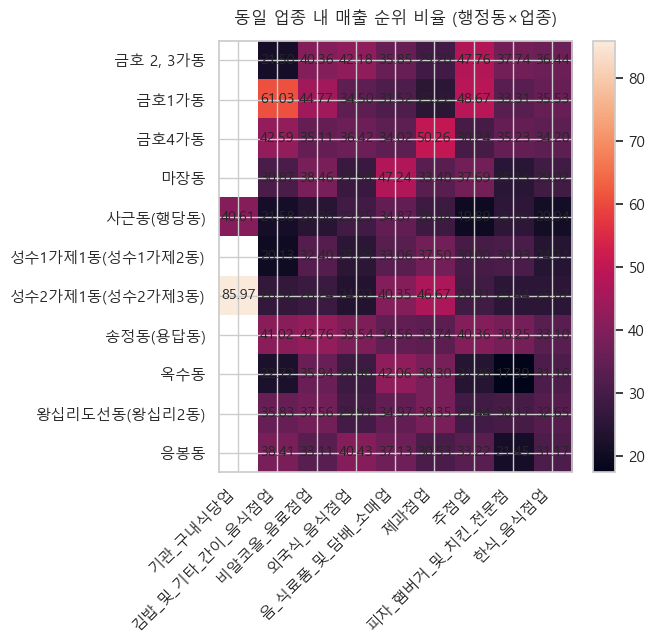

In [85]:
import numpy as np
import matplotlib.pyplot as plt

def heatmap_with_values(mat, title):
    arr = mat.values
    r, c = arr.shape
    plt.figure(figsize=(max(6, c*0.8), max(6, r*0.6)))
    im = plt.imshow(arr, vmin=np.nanmin(arr), vmax=np.nanmax(arr))
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(c), mat.columns, rotation=45, ha='right')
    plt.yticks(range(r), mat.index)
    plt.title(title, pad=12)

    fs = max(6, 12 - 0.15*max(r,c))
    for i in range(r):
        for j in range(c):
            v = arr[i, j]
            if np.isfinite(v):
                plt.text(j, i, f"{v:.2f}", ha='center', va='center', fontsize=fs)
    plt.tight_layout()
    plt.show()

# 그리기 예시
for m, piv in pivots.items():
    heatmap_with_values(piv.round(2), f"{m} (행정동×업종)")


- 취소율 구간(클수록 나쁨)
  - 마장동 제과점 2.97, 금호4가동 제과점 2.82 → 제과점이 몇 동에서 높게 뜸(취소 이슈)

- 재방문 고객 비중(클수록 좋음)
  - 사근동(행당동) 기관_구내식당 52.75% → 강한 충성 고객 업종/동 조합
  - 반대로 금호4가동 주점 16.30%, 사근동 주점 15.03% → 주점 재방문 약함

- 동일 업종 내 매출 순위 비율(클수록 나쁨)
  - 금호1가동 김밥 61.03 → 업종 내 하위권
  - 사근동(행당동) 주점 19.89, 한식 20.94 → 상대적으로 상위권(양호)

In [88]:
# 예: 금호1가동 × 김밥_및_기타_간이_음식점업
target_dong = '금호1가동'
target_cat  = '김밥_및_기타_간이_음식점업'

cols = ['취소율 구간','재방문 고객 비중','동일 업종 내 매출 순위 비율']
sub = df0.query("행정동 == @target_dong and 업종_대분류 == @target_cat")

shops = (sub.groupby('가맹점구분번호')
           .agg(가맹점명=('가맹점명','first'),
                취소율=('취소율 구간','mean'),
                재방문=('재방문 고객 비중','mean'),
                순위비율=('동일 업종 내 매출 순위 비율','mean'),
                표본수=('기준년월','count'))
           .sort_values(['취소율','순위비율','재방문'], ascending=[False, False, True]))
print(shops.head(20).round(2))


                               가맹점명   취소율    재방문   순위비율  표본수
가맹점구분번호                                                     
6BC713A140  불닭*********************  1.54  24.41  38.38   24
1361C9B25C                     사와**  1.45  31.95  62.81   24
8E1FCF09CD              남도*********  1.41  33.27  50.95   23
A294998B2B                    이모***  1.00  54.03  91.56   24


---

#### 최근 3개월에 대한 평균값으로 대체하여 4186개 데이터 추출(shop_tbl)

In [89]:
import pandas as pd
import numpy as np

dfx = df0.copy()

# 1) 기준월(YYYYMM) → Period('M')
dfx['기준월'] = pd.to_datetime(dfx['기준년월'].astype(str), format='%Y%m', errors='coerce').dt.to_period('M')

# 2) 폐업월 파싱: 폐업일이 YYYYMMDD 또는 YYYYMM 형태 가정 → 앞 6자리로 월 추출
def to_close_period(s):
    s = pd.to_numeric(s, errors='coerce')  # float/str 혼재 대비
    s = s.dropna()
    return pd.to_datetime(s.astype(np.int64).astype(str).str[:6], format='%Y%m', errors='coerce').dt.to_period('M')

close_month = pd.Series(index=dfx.index, dtype='period[M]')
mask_close = dfx['폐업일'].notna()
close_month.loc[mask_close] = to_close_period(dfx.loc[mask_close, '폐업일'])
dfx['폐업월'] = close_month

# 3) 점포별 라벨(ever)과 "분석에 쓸 마지막 관측월" 정의
#    - 폐업점: 폐업월 - 1M
#    - 생존점: 그 점포에서 관측된 최대 기준월
last_obs = (dfx
            .assign(last_obs_month=np.where(dfx['폐업월'].notna(),
                                           dfx['폐업월'] - 1,  # 폐업 전월
                                           dfx.groupby('가맹점구분번호')['기준월'].transform('max')))
           )

# 4) 최근 3개월 윈도우(마지막 관측월 포함 뒤로 2개월) 평균으로 점포 단위 요약
#    숫자형 후보(문자 제외)
num_cols = dfx.select_dtypes(include=[np.number]).columns.tolist()
# 점포키/월/라벨에 쓰는 컬럼 제외(필요시 추가 제외)
drop_keys = ['기준년월','개설일','폐업일']  # 숫자지만 의미 다름
num_cols = [c for c in num_cols if c not in drop_keys]

# 라벨(ever)
shop_close = dfx.groupby('가맹점구분번호')['폐업월'].first().notna().astype(int).rename('폐업여부')

# 윈도우 평균 계산
def take_last3_mean(g):
    last_m = g['last_obs_month'].iloc[0]
    if pd.isna(last_m): 
        return pd.Series(dtype='float64')
    win = g[(g['기준월'] <= last_m) & (g['기준월'] >= (last_m - 2))]
    return win[num_cols].mean(numeric_only=True)

shop_feat = (last_obs
             .groupby('가맹점구분번호', group_keys=False)
             .apply(take_last3_mean))

shop_tbl = pd.concat([shop_feat, shop_close], axis=1).dropna(subset=['폐업여부'])

# 5) 폐업 vs 생존 비교: 평균, 표준화 차이, 이진 상관
def summary_rel(df, ycol='폐업여부'):
    y = df[ycol].values
    out = []
    for col in [c for c in df.columns if c != ycol]:
        x = pd.to_numeric(df[col], errors='coerce')
        if x.notna().sum() < 50:  # 표본 너무 적으면 스킵
            continue
        # 그룹 평균
        m1 = x[y==1].mean()
        m0 = x[y==0].mean()
        s  = x.std(ddof=0)
        # 표준화 차이 (m1-m0)/std
        std_diff = (m1 - m0) / s if s and np.isfinite(s) else np.nan
        # 포인트-바이시리얼 상관(=피어슨 with binary y)
        r = np.corrcoef(x.fillna(x.mean()), y)[0,1]  # 결측은 전체평균으로 보수적 대체
        out.append((col, m1, m0, std_diff, r))
    return (pd.DataFrame(out, columns=['feature','mean_close','mean_alive','std_diff','corr_with_close'])
              .sort_values('std_diff', key=lambda s: s.abs(), ascending=False))

rel = summary_rel(shop_tbl)

# 6) 결과 확인
print("▶ 폐업 vs 생존: 표준화 차이 상위 20")
print(rel.head(20).round(3))

print("\n▶ 폐업 비중:", shop_tbl['폐업여부'].mean().round(3), "(점포 수:", len(shop_tbl), ")")


▶ 폐업 vs 생존: 표준화 차이 상위 20
              feature   mean_close   mean_alive  std_diff  corr_with_close
6           배달매출금액 비율       49.678       29.646     0.634            0.027
13     남성 20대이하 고객 비중       14.763       10.849     0.409            0.018
28         E(기타)_이동인구  1060220.144  1329062.246    -0.335           -0.015
25        거주 이용 고객 비율       27.381       34.967    -0.314           -0.014
24           신규 고객 비중        5.979       10.707    -0.311           -0.014
0        가맹점 운영개월수 구간        3.909        3.494     0.290            0.013
17     남성 60대이상 고객 비중        5.902        9.366    -0.288           -0.013
32            평일_이동인구  1992212.277  2320247.245    -0.276           -0.013
27      유동인구 이용 고객 비율       58.749       52.314     0.276            0.012
30      W(주간거주지)_이동인구   671272.857   798309.965    -0.263           -0.012
31            주말_이동인구   624480.190   715785.557    -0.258           -0.012
12  동일 상권 내 해지 가맹점 비중        8.378        8.720    -0.258           -0.008


C:\Users\Bling\AppData\Local\Temp\ipykernel_13804\2699112746.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(take_last3_mean))


- std_diff > 0
  - 배달매출금액 비율(0.634)
    - 폐업점이 배달 의존도가 더 높음

  - 가맹점 운영개월수 구간(0.290)

  - 유동인구 이용 고객 비율(0.276)
    - 폐업점은 유동인구 의존도가 높음

  - 객단가 구간(0.240)
    - 폐업점이 더 나쁜 구간에 있음

  - 매출금액 구간(0.214)
    - 폐업점이 더 나쁜 구간에 있음

  - 유니크 고객 수 구간(0.173)
    - 폐업점이 더 나쁜 구간에 있음

  - 남성 20대이하 고객 비중(0.409)
  - 여성 20대이하 고객 비중(0.169)
    - 젊은층 비중이 상대적으로 높다(청년 의존)

  - 여성 60대이상_생활인구(0.164)
    - 상권의 여성 고령층 생활인구가 많은 지역에 폐업점이 분포하는 경향

- std_diff < 0
  - E(기타)_이동인구(-0.335)
  - 평일_이동인구(-0.276)
  - W(주간거주지)_이동인구(-0.263)
  - 주말_이동인구(-0.258)
    - 폐업점이 전반적인 생활, 이동인구가 적은 지역에 많음

  - 거주 이용 고객 비율(-0.314)
    - 폐업점은 거주인구 의존도가 낮음

  - 신규 고객 비중(-0.311)

  - 동일 상권 내 해지 가맹점 비중(-0.258)

  - 동일 업종 매출건수 비율(-0.201)
    - 폐업점이 업종 평균 대비 거래수 비율이 낮음

  - 남성 60대이상 고객 비중(-0.288)
  - 남성 50대 고객 비중(-0.188)
  - 남성 40대_생활인구(-0.165)
    - 폐업점의 남성 중장년 비중이 낮음

In [90]:
def rate_by_quantile(df, col, q=0.75):
    x = pd.to_numeric(df[col], errors='coerce')
    thr = x.quantile(q)
    hi = df[x >= thr]['폐업여부'].mean()
    lo = df[x <  thr]['폐업여부'].mean()
    return thr, hi, lo
for c in ['배달매출금액 비율','유동인구 이용 고객 비율','거주 이용 고객 비율','남성 20대이하 고객 비중','매출금액 구간']:
    thr, hi, lo = rate_by_quantile(shop_tbl, c, 0.75 if c!='거주 이용 고객 비율' else 0.25)
    print(f"{c} 기준 {thr:.2f}: 상집단 폐업율 {hi:.3f}, 하집단 {lo:.3f}")


배달매출금액 비율 기준 49.80: 상집단 폐업율 0.028, 하집단 0.008
유동인구 이용 고객 비율 기준 68.28: 상집단 폐업율 0.007, 하집단 0.008
거주 이용 고객 비율 기준 14.26: 상집단 폐업율 0.007, 하집단 0.009
남성 20대이하 고객 비중 기준 15.18: 상집단 폐업율 0.013, 하집단 0.006
매출금액 구간 기준 4.67: 상집단 폐업율 0.012, 하집단 0.007


In [91]:
p75 = shop_tbl['배달매출금액 비율'].quantile(0.75)
p25 = shop_tbl['재방문 고객 비중'].quantile(0.25)
m = (shop_tbl['배달매출금액 비율']>=p75) & (shop_tbl['재방문 고객 비중']<=p25)
print("교차조건 폐업율:", shop_tbl.loc[m,'폐업여부'].mean(), " / 나머지:", shop_tbl.loc[~m,'폐업여부'].mean())


교차조건 폐업율: 0.0410958904109589  / 나머지: 0.03017031630170316


- 배달비율
  - 상위 25%는 폐업률 2.8%, 하위 25%는 0.8%
  - 배달 채널 변동(수수료/노출/리뷰 등)에 민감한 구조
- 유동 의존/거주 의존
  - 단일 비교는 차이가 작지만
  - 배달 상위 & 재방문 하위 : 4.11% vs. 3.02%
    - > 단골이 약한 배달형이 특히 취약
- 젊은층(남성20대이하) 비중이 클수록 위험(1.3% vs. 0.6%)
  - > 수요 변동/이탈에 더 흔들림
- 매출금액 구간이 높을수록 위험(1.2% vs. 0.7%)
  - > 이미 성과 저하가 진행 중인 가게가 닫힐 확률이 높음

In [92]:
tbl = shop_tbl  # 점포 단위 요약 테이블

# 임계값 재계산(이미 계산했다면 건너뛰어도 됨)
p75_deliv = tbl['배달매출금액 비율'].quantile(0.75)
p25_repeat = tbl['재방문 고객 비중'].quantile(0.25)

m = (tbl['배달매출금액 비율'] >= p75_deliv) & (tbl['재방문 고객 비중'] <= p25_repeat)

rate_in  = tbl.loc[m, '폐업여부'].mean()
rate_out = tbl.loc[~m,'폐업여부'].mean()
base     = tbl['폐업여부'].mean()

print("전체 폐업률:", round(base,4))
print("조건 집단 폐업률:", round(rate_in,4), "표본수:", m.sum())
print("나머지 폐업률:", round(rate_out,4), "표본수:", (~m).sum())
print("조건 집단 비중:", round(m.mean(),4))


전체 폐업률: 0.0304
조건 집단 폐업률: 0.0411 표본수: 73
나머지 폐업률: 0.0302 표본수: 4110
조건 집단 비중: 0.0175


- 조건 집단(73개)에서의 폐업률 0.0411 = (조건 충족 & 폐업 가맹점 수) / 73
  - → 대략 3곳(0.0411×73 ≈ 3)

- 나머지 집단(4110개)에서의 폐업률 0.0302 = (조건 미충족 & 폐업 가맹점 수) / 4110
  - → 대략 124곳(0.0302×4110 ≈ 124)

- 두 집단 합 3 + 124 ≈ 127 = 전체 폐업 가맹점 수와 일치

- 전체 폐업률 0.0304 ≈ 127 / 4183

- 조건 집단 비중 0.0175 = 73 / 4183 (전체의 **1.75%**가 조건 충족)

In [108]:
shop_tbl.columns

Index(['가맹점 운영개월수 구간', '매출금액 구간', '매출건수 구간', '유니크 고객 수 구간', '객단가 구간', '취소율 구간',
       '배달매출금액 비율', '동일 업종 매출금액 비율', '동일 업종 매출건수 비율', '동일 업종 내 매출 순위 비율',
       '동일 상권 내 매출 순위 비율', '동일 업종 내 해지 가맹점 비중', '동일 상권 내 해지 가맹점 비중',
       '남성 20대이하 고객 비중', '남성 30대 고객 비중', '남성 40대 고객 비중', '남성 50대 고객 비중',
       '남성 60대이상 고객 비중', '여성 20대이하 고객 비중', '여성 30대 고객 비중', '여성 40대 고객 비중',
       '여성 50대 고객 비중', '여성 60대이상 고객 비중', '재방문 고객 비중', '신규 고객 비중',
       '거주 이용 고객 비율', '직장 이용 고객 비율', '유동인구 이용 고객 비율', 'E(기타)_이동인구',
       'H(야간거주지)_이동인구', 'W(주간거주지)_이동인구', '주말_이동인구', '평일_이동인구', '총생활인구수',
       '남성 20대이하_생활인구', '남성 30대_생활인구', '남성 40대_생활인구', '남성 50대_생활인구',
       '남성 60대이상_생활인구', '여성 20대이하_생활인구', '여성 30대_생활인구', '여성 40대_생활인구',
       '여성 50대_생활인구', '여성 60대이상_생활인구', '폐업여부'],
      dtype='object')

---

In [63]:
# import pandas as pd
# import numpy as np

# # 기준년월 → Period(M): YYYYMM / YYYY-MM 등 혼재 허용
# def to_month_period(s):
#     s = s.astype(str).str.strip()
#     only = s.str.replace(r'[^0-9]', '', regex=True).str.zfill(6)  # 숫자만, 6자리 보정
#     dt = pd.to_datetime(only, format='%Y%m', errors='coerce')
#     return dt.dt.to_period('M')

# # 폐업일 → Period(M): YYYYMMDD / YYYYMM / YYYY / 섞여 있어도 처리
# def close_to_month_period(s):
#     s = s.astype(str).str.strip()
#     only = s.str.replace(r'[^0-9]', '', regex=True)

#     # 1) NaT로 전부 채운 다음 포맷별로 채워넣기 (길이 불일치 방지 핵심)
#     dt = pd.Series(pd.NaT, index=s.index, dtype='datetime64[ns]')

#     mask8 = only.str.len() == 8   # YYYYMMDD
#     dt.loc[mask8] = pd.to_datetime(only.loc[mask8], format='%Y%m%d', errors='coerce')

#     mask6 = only.str.len() == 6   # YYYYMM
#     dt.loc[mask6] = pd.to_datetime(only.loc[mask6], format='%Y%m', errors='coerce')

#     mask4 = only.str.len() == 4   # YYYY
#     dt.loc[mask4] = pd.to_datetime(only.loc[mask4] + "01", format='%Y%m', errors='coerce')

#     return dt.dt.to_period('M')

# # 적용
# df = final.copy()
# df['기준월_p'] = to_month_period(df['기준년월'])
# df['폐업월_p'] = close_to_month_period(df['폐업일'])

# # 라벨 생성: 기준월에서 6개월 내 폐업이면 1
# horizon = 6
# def make_label(g):
#     g = g.sort_values('기준월_p')
#     g['label_6m'] = 0
#     if g['폐업월_p'].notna().any():
#         delta_m = (g['폐업월_p'].astype('period[M]') - g['기준월_p'].astype('period[M]')).astype('Int64')
#         g.loc[delta_m.between(0, horizon, inclusive='both'), 'label_6m'] = 1
#     return g

# df = df.groupby('가맹점구분번호', group_keys=False).apply(make_label)
# print("라벨 비율:", df['label_6m'].mean())
